<a href="https://colab.research.google.com/github/ahmedelalaoui142/Forecasting_financial_time_series/blob/main/INTERNSHIP16_Predicting_using_hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Optional: Set random seeds for reproducibility
import tensorflow as tf
import random
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [44]:
# Define start and end dates
start_date = '2014-01-01'
end_date = '2024-09-01'  # Adjusted to the latest available date if necessary

# Download Microsoft stock data
df = yf.download('MSFT', start=start_date, end=end_date)
df.sort_index(inplace=True)

# Use only the 'Close' column
data = df[['Close']]


[*********************100%***********************]  1 of 1 completed


In [45]:
# Assuming 'data' contains data up to '2024-09-01'

# Define the cutoff date for the last two months
# If 'data' doesn't have data up to '2024-09-01', this will adjust to the latest available date
last_date = data.index[-1]
cutoff_date = last_date - pd.DateOffset(months=2)

# Split data into training and future (testing) sets
train_data = data[data.index <= cutoff_date]
future_data = data[data.index > cutoff_date]

print(f"Training data end date: {train_data.index[-1].date()}")
print(f"Future data start date: {future_data.index[0].date()}")


Training data end date: 2024-06-28
Future data start date: 2024-07-01


In [46]:
# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)


In [47]:
# Define the lookback period
lookback = 90

# Function to create sequences
def create_sequences(dataset, lookback):
    X, Y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

# Create sequences from the scaled training data
X_train, y_train = create_sequences(scaled_train_data, lookback)

# Reshape X_train to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (2550, 90, 1)
y_train shape: (2550,)


In [48]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(units=150))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0132
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1519e-04
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.6983e-04
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6440e-04
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.5368e-04
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.3376e-04
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2198e-04
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.1141e-04
Epoch 9/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.9592e-04
Epoch 10/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.7825e-04
Epoch 11/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6945e-04
Epoch 12/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6633e-04
Epoch 13/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6262e-04
Epoch 14/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.5943e-04


In [50]:
# Number of days to predict (number of entries in future_data)
future_days = len(future_data)

# Get the last lookback days from the training data
last_sequence = scaled_train_data[-lookback:]


In [51]:
# Initialize a list to store predictions
future_predictions = []

# Predict future prices
for _ in range(future_days):
    # Prepare the input data
    input_seq = np.reshape(last_sequence, (1, lookback, 1))
    # Make the prediction
    next_pred = model.predict(input_seq)
    # Reshape next_pred to have shape (1, 1)
    next_pred = next_pred.reshape(-1, 1)
    # Append the prediction
    future_predictions.append(next_pred[0, 0])
    # Update the last_sequence by appending the prediction and removing the first element
    last_sequence = np.concatenate((last_sequence[1:], next_pred), axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [52]:
# Inverse transform the predictions
future_predictions = np.array(future_predictions)
future_predictions = future_predictions.reshape(-1, 1)
future_predictions_inv = scaler.inverse_transform(future_predictions)

In [53]:
actual_prices = future_data['Close'].values

In [54]:
rmse = np.sqrt(mean_squared_error(actual_prices, future_predictions_inv))
mape = mean_absolute_percentage_error(actual_prices, future_predictions_inv)

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.4f}')

RMSE: 22.49
MAPE: 0.0471


In [55]:
future_dates = future_data.index
predicted_prices = future_predictions_inv.flatten()

comparison_df = pd.DataFrame({
    'Date': future_dates,
    'Actual': actual_prices,
    'Predicted': predicted_prices
})

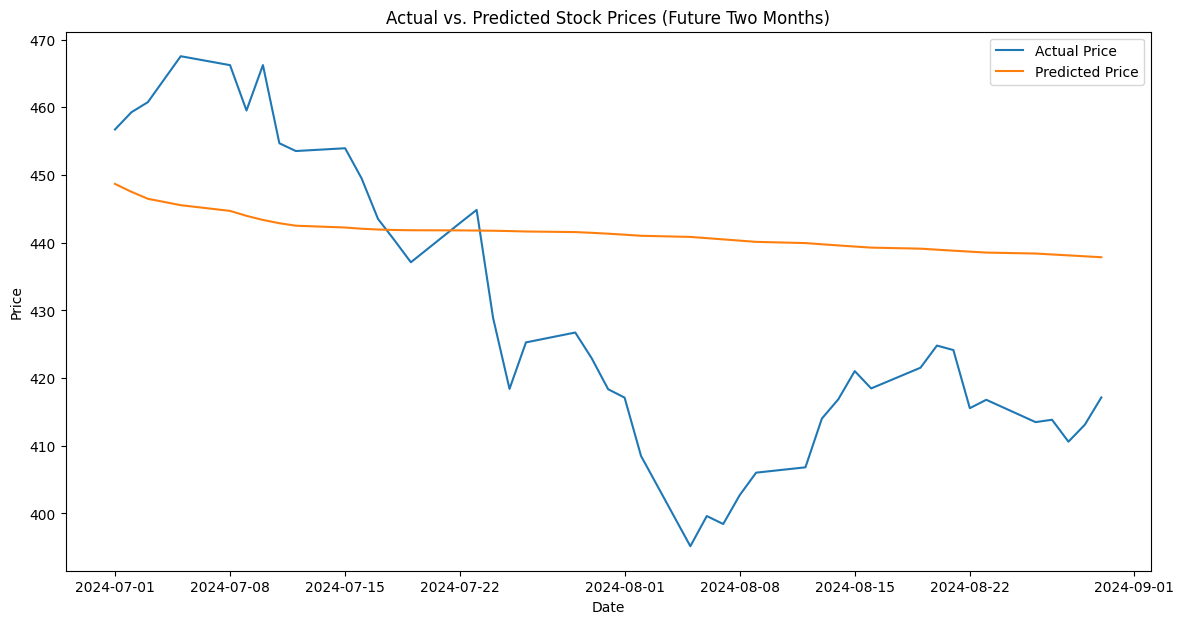

In [56]:

# Plot the actual vs. predicted prices
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual Price')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted Price')
plt.title('Actual vs. Predicted Stock Prices (Future Two Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [59]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from prophet import Prophet

# Step 1: Download data and preprocess (as in your original LSTM code)
start_date = '2014-01-01'
end_date = '2024-09-01'
df = yf.download('MSFT', start=start_date, end=end_date)
df.sort_index(inplace=True)
data = df[['Close']]

# Define cutoff date for the last two months
last_date = data.index[-1]
cutoff_date = last_date - pd.DateOffset(months=2)
train_data = data[data.index <= cutoff_date]
future_data = data[data.index > cutoff_date]

# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)

lookback = 90

# Create sequences for LSTM model
def create_sequences(dataset, lookback):
    X, Y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_sequences(scaled_train_data, lookback)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(units=150))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Predict future prices using LSTM
future_days = len(future_data)
last_sequence = scaled_train_data[-lookback:]
future_predictions = []

for _ in range(future_days):
    input_seq = np.reshape(last_sequence, (1, lookback, 1))
    next_pred = model.predict(input_seq)
    next_pred = next_pred.reshape(-1, 1)
    future_predictions.append(next_pred[0, 0])
    last_sequence = np.concatenate((last_sequence[1:], next_pred), axis=0)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_inv = scaler.inverse_transform(future_predictions)
lstm_dates = future_data.index
lstm_predicted_prices = future_predictions_inv.flatten()

# Step 2: Prophet model predictions
prophet_df = yf.download('MSFT', '2014-01-01', '2024-07-01')
prophet_df.reset_index(inplace=True)
prophet_df = prophet_df[['Date', 'Close', 'Volume']]
prophet_df.columns = ['ds', 'y', 'volume']

# Train Prophet model
prophet_model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=5,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
prophet_model.add_regressor('volume')
prophet_model.fit(prophet_df)

# Predict future dates with Prophet
future_dates = prophet_model.make_future_dataframe(periods=60)
future_dates['volume'] = prophet_df['volume'].iloc[-1]
prophet_predictions = prophet_model.predict(future_dates)

# Filter Prophet predictions to match actual future data
actual_future_df = yf.download('MSFT', '2024-07-01', '2024-09-15')
actual_future_df.reset_index(inplace=True)
actual_future_df = actual_future_df[['Date', 'Close']]
actual_future_df.columns = ['ds', 'actual']
merged_prophet_df = pd.merge(prophet_predictions[['ds', 'yhat']], actual_future_df, on='ds', how='left')
prophet_future_df = merged_prophet_df[merged_prophet_df['ds'] > '2024-07-01'].dropna(subset=['actual'])

# Step 3: Combine predictions
prophet_future_df['LSTM_Predicted'] = lstm_predicted_prices
prophet_future_df['Combined_Predicted'] = (prophet_future_df['yhat'] + prophet_future_df['LSTM_Predicted']) / 2

# Step 4: Calculate RMSE and MAPE
combined_rmse = np.sqrt(mean_squared_error(prophet_future_df['actual'], prophet_future_df['Combined_Predicted']))
combined_mape = mean_absolute_percentage_error(prophet_future_df['actual'], prophet_future_df['Combined_Predicted'])

print(f'Combined RMSE: {combined_rmse:.2f}')
print(f'Combined MAPE: {combined_mape:.4f}')

# Step 5: Plot combined predictions
plt.figure(figsize=(14, 7))
plt.plot(prophet_future_df['ds'], prophet_future_df['actual'], label='Actual Price')
plt.plot(prophet_future_df['ds'], prophet_future_df['Combined_Predicted'], label='Combined Predicted Price', linestyle='--')
plt.title('Actual vs. Combined Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0123
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7126e-04
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7179e-04
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5781e-04
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2791e-04
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0489e-04
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.9963e-04
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.9617e-04
Epoch 9/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9171e-04
Epoch 10/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.8565e-04
Epoch 11/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.7836e-04
Epoch 12/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.7006e-04
Epoch 13/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.6111e-04
Epoch 14/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5232e-04
Epoch 15/20


[*********************100%***********************]  1 of 1 completed
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6z2gjahi/4sre98sr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6z2gjahi/klygbos5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73430', 'data', 'file=/tmp/tmp6z2gjahi/4sre98sr.json', 'init=/tmp/tmp6z2gjahi/klygbos5.json', 'output', 'file=/tmp/tmp6z2gjahi/prophet_modely1fzynq_/prophet_model-20240929142658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:27:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[*********************100%***********************]  1 of 1 completed


ValueError: Length of values (44) does not match length of index (40)

Length of LSTM predictions: 44
Length of Prophet predictions: 40
Combined RMSE: 19.67
Combined MAPE: 0.0407


<ipython-input-60-1077e3977ef3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_future_df['LSTM_Predicted'] = lstm_predicted_prices
<ipython-input-60-1077e3977ef3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_future_df['Combined_Predicted'] = (prophet_future_df['yhat'] + prophet_future_df['LSTM_Predicted']) / 2


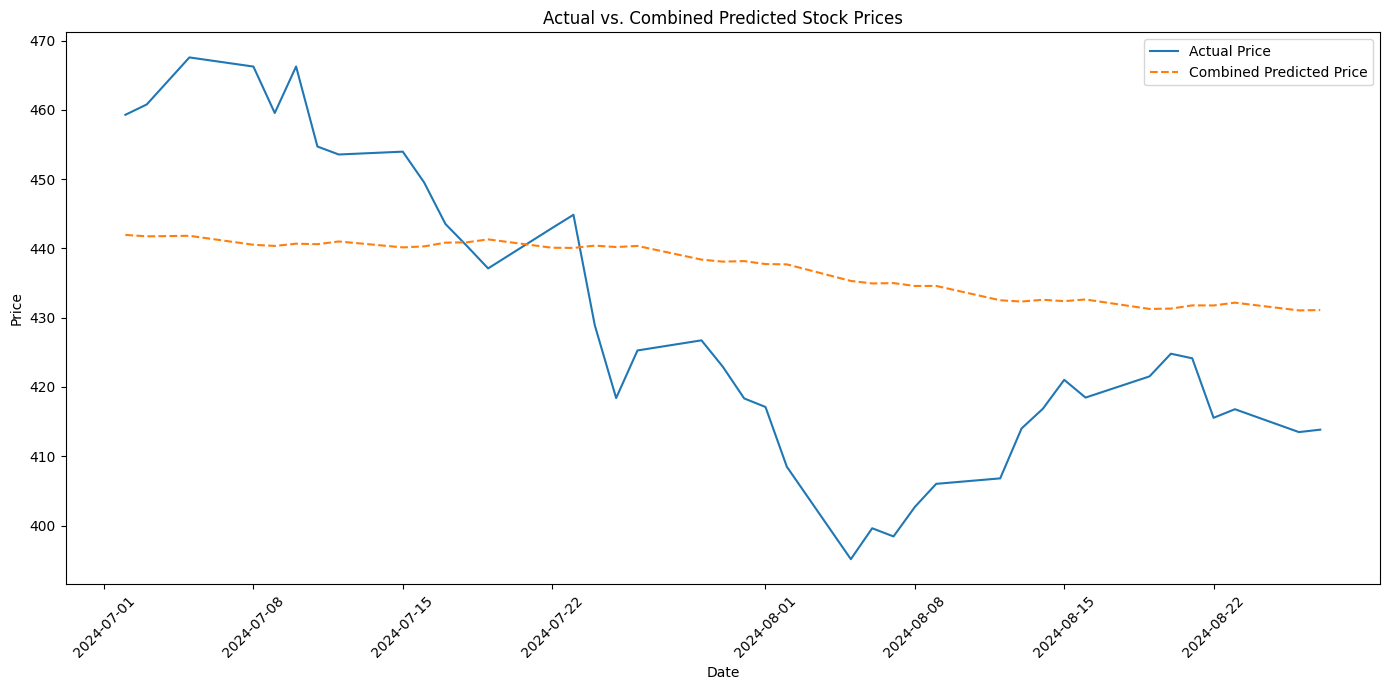

In [60]:
# Print lengths of both series to debug
print(f"Length of LSTM predictions: {len(lstm_predicted_prices)}")
print(f"Length of Prophet predictions: {len(prophet_future_df)}")

# If lengths are different, align them
min_length = min(len(lstm_predicted_prices), len(prophet_future_df))

# Trim both series to the minimum length
lstm_predicted_prices = lstm_predicted_prices[:min_length]
prophet_future_df = prophet_future_df.iloc[:min_length]

# Now combine the predictions
prophet_future_df['LSTM_Predicted'] = lstm_predicted_prices
prophet_future_df['Combined_Predicted'] = (prophet_future_df['yhat'] + prophet_future_df['LSTM_Predicted']) / 2

# Continue with RMSE, MAPE calculation and plotting
combined_rmse = np.sqrt(mean_squared_error(prophet_future_df['actual'], prophet_future_df['Combined_Predicted']))
combined_mape = mean_absolute_percentage_error(prophet_future_df['actual'], prophet_future_df['Combined_Predicted'])

print(f'Combined RMSE: {combined_rmse:.2f}')
print(f'Combined MAPE: {combined_mape:.4f}')

# Plot combined predictions
plt.figure(figsize=(14, 7))
plt.plot(prophet_future_df['ds'], prophet_future_df['actual'], label='Actual Price')
plt.plot(prophet_future_df['ds'], prophet_future_df['Combined_Predicted'], label='Combined Predicted Price', linestyle='--')
plt.title('Actual vs. Combined Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-61-a8b6c97e3642>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_future_df['Actual_Direction'] = (prophet_future_df['actual'].diff() > 0).astype(int)
<ipython-input-61-a8b6c97e3642>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_future_df['Combined_Direction'] = (prophet_future_df['Combined_Predicted'].diff() > 0).astype(int)


Accuracy of Direction Prediction: 47.50%


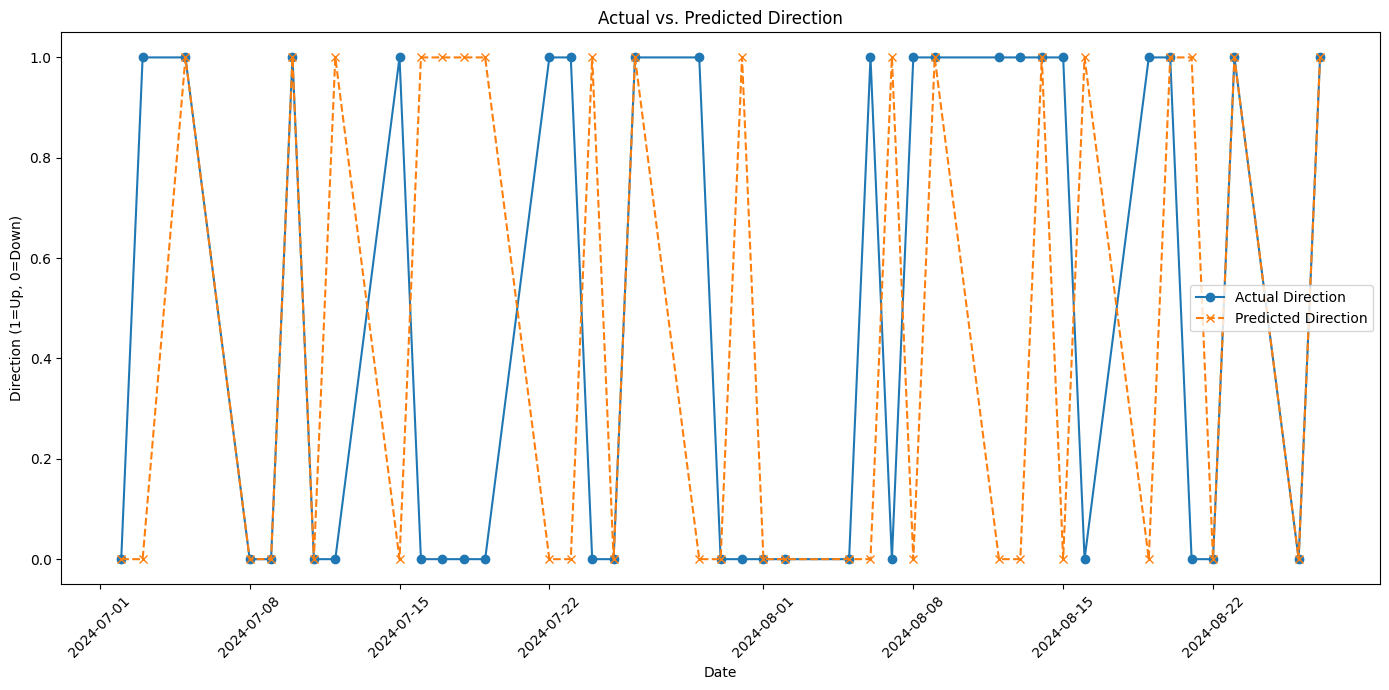

In [61]:
# Step 1: Create the direction variable
# Actual direction: 1 if price increased, 0 if decreased
prophet_future_df['Actual_Direction'] = (prophet_future_df['actual'].diff() > 0).astype(int)

# Combined predicted direction: 1 if predicted price increased, 0 if decreased
prophet_future_df['Combined_Direction'] = (prophet_future_df['Combined_Predicted'].diff() > 0).astype(int)

# Step 2: Calculate accuracy
accuracy = (prophet_future_df['Actual_Direction'] == prophet_future_df['Combined_Direction']).mean()
print(f'Accuracy of Direction Prediction: {accuracy * 100:.2f}%')

# Step 3: Plot the direction variables
plt.figure(figsize=(14, 7))
plt.plot(prophet_future_df['ds'], prophet_future_df['Actual_Direction'], label='Actual Direction', marker='o')
plt.plot(prophet_future_df['ds'], prophet_future_df['Combined_Direction'], label='Predicted Direction', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Direction')
plt.xlabel('Date')
plt.ylabel('Direction (1=Up, 0=Down)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [62]:
print(f"Length of future_data (LSTM): {len(future_data)}")


Length of future_data (LSTM): 44


In [63]:
# Align LSTM future data with Prophet future data dates
lstm_future_dates = future_data.index[:len(prophet_future_df)]
lstm_predicted_prices = lstm_predicted_prices[:len(lstm_future_dates)]

# Verify the alignment of lengths after trimming
print(f"Adjusted Length of LSTM predictions: {len(lstm_predicted_prices)}")
print(f"Adjusted Length of Prophet predictions: {len(prophet_future_df)}")


Adjusted Length of LSTM predictions: 40
Adjusted Length of Prophet predictions: 40


Length of LSTM predictions: 40
Length of Prophet predictions: 40
Accuracy of Direction Prediction: 47.50%


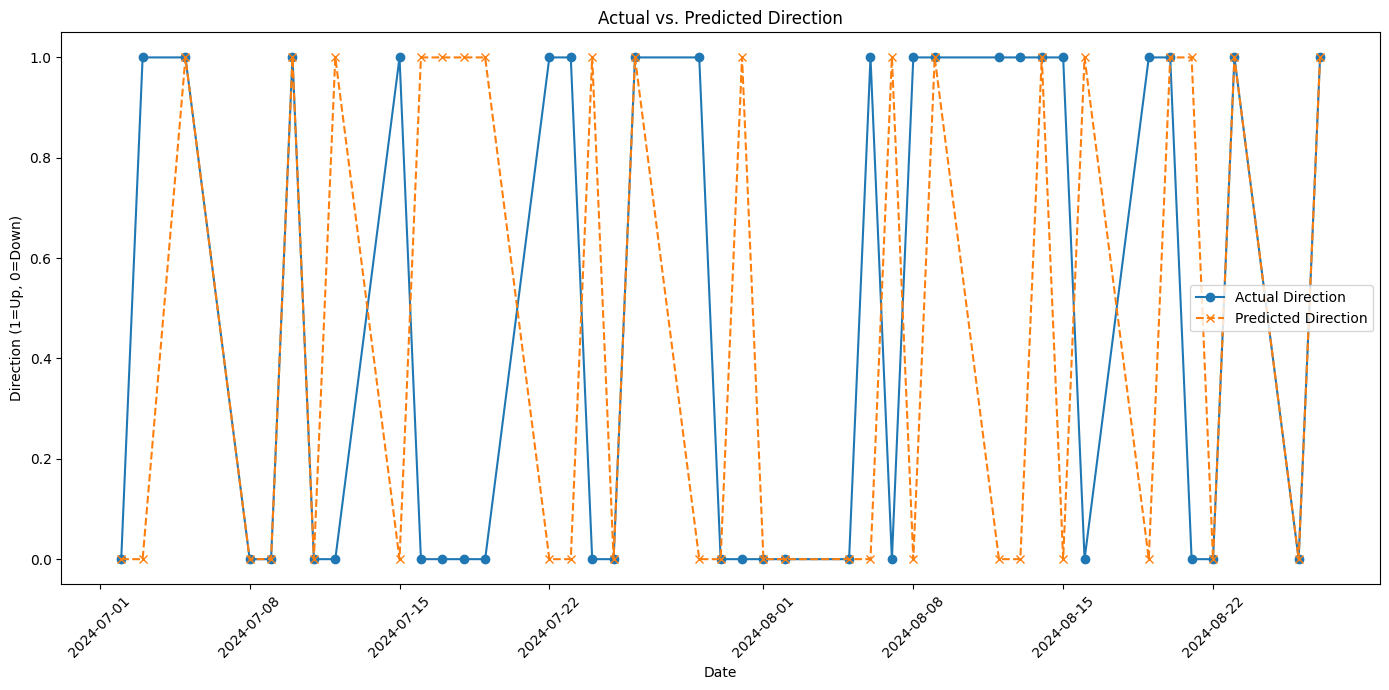

In [65]:
# Print lengths for debugging
print(f"Length of LSTM predictions: {len(lstm_predicted_prices)}")
print(f"Length of Prophet predictions: {len(prophet_future_df)}")

# Step 1: Align LSTM predictions to Prophet's future dates
# Get the dates that are in both the LSTM dates and Prophet future DataFrame
common_dates = prophet_future_df['ds']

# Ensure LSTM predictions have the same length as the common dates
lstm_predicted_prices_aligned = lstm_predicted_prices[:len(common_dates)]

# Step 2: Trim Prophet future DataFrame if necessary
prophet_future_df = prophet_future_df.iloc[:len(lstm_predicted_prices_aligned)]

# Step 3: Combine predictions
prophet_future_df['LSTM_Predicted'] = lstm_predicted_prices_aligned
prophet_future_df['Combined_Predicted'] = (prophet_future_df['yhat'] + prophet_future_df['LSTM_Predicted']) / 2

# Step 4: Calculate direction and accuracy
prophet_future_df['Actual_Direction'] = (prophet_future_df['actual'].diff() > 0).astype(int)
prophet_future_df['Combined_Direction'] = (prophet_future_df['Combined_Predicted'].diff() > 0).astype(int)

accuracy = (prophet_future_df['Actual_Direction'] == prophet_future_df['Combined_Direction']).mean()
print(f'Accuracy of Direction Prediction: {accuracy * 100:.2f}%')

# Step 5: Plot the actual and predicted directions
plt.figure(figsize=(14, 7))
plt.plot(prophet_future_df['ds'], prophet_future_df['Actual_Direction'], label='Actual Direction', marker='o')
plt.plot(prophet_future_df['ds'], prophet_future_df['Combined_Direction'], label='Predicted Direction', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Direction')
plt.xlabel('Date')
plt.ylabel('Direction (1=Up, 0=Down)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
